###  Imports

In [1]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

### Get data from Reddit

In [3]:
depressedData = pd.read_csv('./../../Data/depressed_posts.csv')
unpopularopinionData = pd.read_csv('./../../Data/unpopularopinion_posts.csv')
lonelyData = pd.read_csv('./../../Data/lonely_posts.csv')
machinelearningData = pd.read_csv('./../../Data/machinelearning_posts.csv')

### Clean r/depression data

In [4]:
print(len(depressedData))

998


In [5]:
depressedData = depressedData[depressedData['Post'].notna()]
print(len(depressedData))

979


In [6]:
depressedData['Post'] = depressedData['Post'].astype(str)
print(len(depressedData))

979


In [7]:
allPosts = depressedData

urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+(\.\d+)?'
posessivePronouns = '’s'
apostrophe='’'
someSigns ='\\n|\\r'
punctuation = "[^\w\s]" 
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

allPosts['Post_Parsed'] = allPosts['Post'].str.lower()
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(urls,'url',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(numbers,'nmbr',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(posessivePronouns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(apostrophe,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(someSigns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(punctuation,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(whitespaces,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(leadTrailWhitespace,'',regex=True)

In [8]:
allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed
0,username123456111111,depression,1.620596e+09,i just want to time travel back and fix my mis...,(english is my second language so sorry if i m...,english is my second language so sorry if i ma...
1,iSlurpees,depression,1.620602e+09,Is this depression,"I felt on top of the world Friday night, every...",i felt on top of the world friday night everyt...
2,Awkward-Cat98,depression,1.620643e+09,White hair due to stress and depression,"Hi everyone, \nI really want to hear if anyone...",hi everyone i really want to hear if anyone ha...
3,kitkatpaddywat,depression,1.620593e+09,Everything is “getting back to normal”,And it’s making me super depressed. I have not...,and it making me super depressed i have nothin...
4,sugarpopp,depression,1.620508e+09,Am I happy or am I delusional in my bubble?,"I am 25F, gonna turn 26 on 15th May. have been...",i am nmbrf gonna turn nmbr on nmbrth may have ...


In [14]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [16]:
nrows = len(allPosts)
lemmatized_text_list = []

for post in allPosts.Post_Parsed:
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = post
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [17]:
allPosts['Post_Parsed'] = lemmatized_text_list

In [18]:
allPosts.loc[1]['Post_Parsed']

'i felt on top of the world friday night everything be go for me now i just feel so low and like im put on an act whenever im with people i let myself get walk all over and dont care i keep ask myself who would care if i didnt come home i drink and dont stop because it make me the life of the party for a few hours make me not feel small for a while but then i go back to be alone and the thoughts start come back'

In [21]:
# stop words
with open('./../../stop_words_no_punct.data', 'rb') as filehandle:
    # read the data as binary data stream
    stop_words_no_punct = pickle.load(filehandle)

In [22]:
from nltk.tokenize import word_tokenize
post_without_stop_words = []

for post in allPosts.Post_Parsed:
    text_tokens = word_tokenize(post)
    tokens_without_stop_words = [word for word in text_tokens if not word in stop_words_no_punct]
    post_without_stop_words.append((" ").join(tokens_without_stop_words))

allPosts['Post_Parsed'] = post_without_stop_words

In [23]:
allPosts.loc[1]['Post_Parsed']

'felt top world friday night everything go feel low like im put act whenever im people let get walk care keep ask would care come home drink stop make life party hours make feel small go back alone thoughts start come back'

In [24]:
depressedData = allPosts

depressedData.to_csv('depression_posts_processed.csv', index=False)

### Generating Features

In [25]:
from nltk.tokenize import word_tokenize

def getWordFrequency(processedPostOutputFile):
    posts = pd.read_csv(processedPostOutputFile)

    allPostsConcat = ''
    for post in posts.Post_Parsed:
        if(type(post)==str):
            allPostsConcat+=post

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    for word in words:
        all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

In [26]:
freqWordsDepression = getWordFrequency('depression_posts_processed.csv')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsDepression)))
print('Most common words: {}'.format(freqWordsDepression.most_common(100)))

word_features_depression = list(freqWordsDepression.keys())[:1500]

Number of words: 7251
Most common words: [('feel', 1533), ('like', 1260), ('get', 1181), ('im', 971), ('want', 917), ('nmbr', 912), ('know', 900), ('go', 822), ('life', 735), ('think', 671), ('even', 669), ('make', 655), ('time', 643), ('really', 496), ('people', 494), ('try', 462), ('say', 461), ('tell', 429), ('would', 426), ('one', 414), ('never', 394), ('depression', 381), ('things', 376), ('take', 370), ('work', 366), ('start', 359), ('day', 355), ('much', 349), ('live', 346), ('help', 338), ('years', 333), ('ive', 316), ('friends', 311), ('see', 306), ('good', 305), ('talk', 298), ('fuck', 296), ('still', 295), ('anything', 291), ('cant', 290), ('always', 287), ('back', 282), ('everything', 268), ('way', 261), ('nothing', 255), ('bad', 255), ('depress', 254), ('job', 251), ('love', 249), ('something', 249), ('need', 242), ('better', 240), ('leave', 239), ('could', 234), ('end', 233), ('anymore', 232), ('come', 229), ('someone', 229), ('anyone', 226), ('lose', 226), ('care', 223),

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


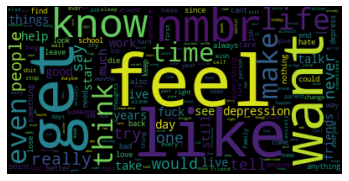

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
nltk.download('webtext')
data_analysis = freqWordsDepression
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
 
wcloud = WordCloud().generate_from_frequencies(filter_words)
 
# Plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

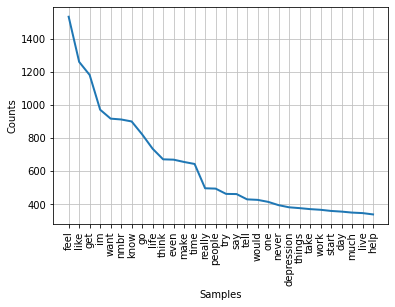

In [28]:
import matplotlib.pyplot as plt
freqWordsDepression.plot(30,cumulative=False)
plt.show()